# Hypothesis testing for leakage assessment of timing side channel

## 1. Collect the measurements

First, we need to collect as clean measurements as possible.

Prepare your system:
- Disable turboboost (check `intel_pstate` is the active driver with `cat /sys/devices/system/cpu/cpu*/cpufreq/scaling_driver`; then execute `echo "1" | sudo tee /sys/devices/system/cpu/intel_pstate/no_turbo`; revert after measurement)
- Fix the frequency of some core using `cpupower frequency-set -d 1900Mhz`
- Set `echo 1000000 > /proc/sys/kernel/sched_rt_runtime_us` to enable real-time process to use 100% of CPU (no scheduling)
- Start the process with `taskset 0x2 chrt -f 99 php tests/consttime/collect.php` (run on core 0 or 1 with high priority)

## 2. Assess measurement quality

First, we assess the measurement quality. If the measurement quality is poor, the results are irrelevant.

In [57]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import json

In [58]:
def load_json_from_file(file_path):
  with open(file_path, 'r') as f:
    return json.load(f)

data = load_json_from_file('measurements/SWUnsafeMath_secp192r1_500.json')

### 2.1 The iteration must be irrelevant

Measurement proceeds in iterations, and in each iteration all testcases are executed and measured. Hence the timing for each iteration should be the same.

On a real machine, reaching this is hard, even when configuring it properly (see chapter 1). Hence we first remove iterations that are slower than the rest. You can adjust the behaviour with the following parameter: `iteration_selectivity` defines how many iterations are kept, i.e. only one out of `iteration_selectivity` iterations.

In [59]:
def get_measurements_per_iteration(samples):
    measurements_per_iteration = {}
    for iteration in range(0, len(samples[0]['measurements'])):
        measurements_per_iteration[iteration] = []

    for sample in samples:
        for iteration, measurement in enumerate(sample['measurements']):
            measurements_per_iteration[iteration].append(measurement['time'])

    return measurements_per_iteration

measurements_per_iteration = get_measurements_per_iteration(data['samples'])
measurements_per_iteration_sum = [__builtins__.sum(measurements_per_iteration[i]) for i in measurements_per_iteration]

iteration_selectivity = 4
threshold = sorted(measurements_per_iteration_sum)[int(len(measurements_per_iteration_sum)/iteration_selectivity)]
remove_iterations = []
for index, sum in enumerate(measurements_per_iteration_sum):
    if sum > threshold:
        remove_iterations.append(index)

cleaned_samples = []
for sample in data['samples']:
    cleaned_measurements = []
    for index, measurement in enumerate(sample['measurements']):
        if index not in remove_iterations:
            cleaned_measurements.append(measurement)
    cleaned_sample = sample.copy()
    cleaned_sample['measurements'] = cleaned_measurements
    cleaned_samples.append(cleaned_sample)

**Check the graph.** If the measurement is accurate, then for each iteration, the timings are the same.

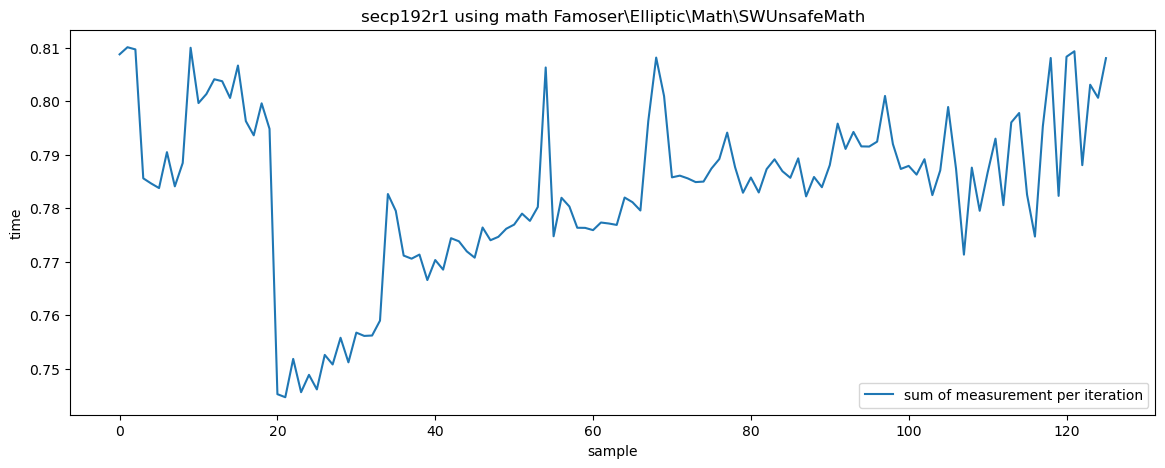

In [60]:
measurements_per_iteration = get_measurements_per_iteration(cleaned_samples)
measurements_per_iteration_sum = [__builtins__.sum(measurements_per_iteration[i]) for i in measurements_per_iteration]

plt.figure(figsize=(14,5))
plt.plot(measurements_per_iteration_sum, label='sum of measurement per iteration')
plt.title(data['curve'] + ' using math ' + data['math'])
plt.xlabel('sample')
plt.ylabel('time')
plt.legend()
plt.show()

### 2.2. Testcase index must be irrelevant

To avoid side-effects in between the testcases (e.g. by the branch predictor or other forms of caching), we randomize the order of the testcases for each iteration. If the randomization is non-biased, and caching is successfully made irrelevant, then for each testcase index the measurement should be the same.

**Check the graph.** If the measurement is accurate, then for each test index, the timings are the same.

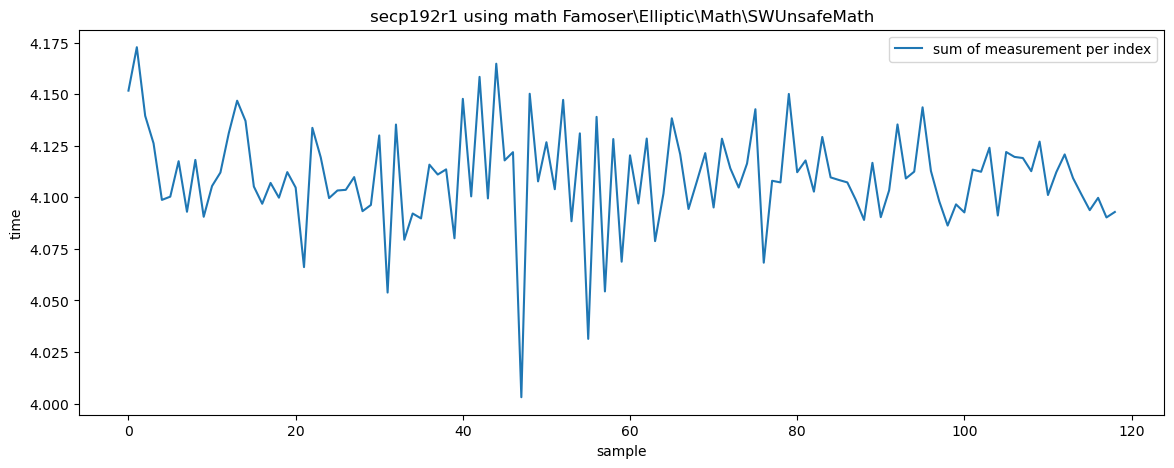

In [61]:
def get_measurements_per_index(samples):
    measurements_per_index = {}
    for index in range(0, len(samples)):
        measurements_per_index[index] = []

    for sample in samples:
        for measurement in sample['measurements']:
            measurements_per_index[measurement['index']].append(measurement['time'])

    return measurements_per_index

measurement_per_index = get_measurements_per_index(cleaned_samples)
measurements_per_index_sum = [__builtins__.sum(measurements_per_index[i]) for i in measurements_per_index]

plt.figure(figsize=(14,5))
plt.plot(measurements_per_index_sum, label='sum of measurement per index')
plt.title(data['curve'] + ' using math ' + data['math'])
plt.xlabel('sample')
plt.ylabel('time')
plt.legend()
plt.show()

### 3. Assess measurement result

If chapter 2 does not show signs of a botched measurement, we can now proceed to assess the measurement result.

### 3.1. Measurements per flag

We quantify by flag. Flags usually indicate the type of the testcase, possibly special chosen (e.g. to multiply by 0 or similar). Note that not all testsets have a lot (of useful) flags.

In [65]:
def get_measurements_per_flag(samples):
    measurements_per_flag = {'NONE': []}
    for sample in samples:
        for flag in sample['flags']:
            if flag not in measurements_per_flag:
                measurements_per_flag[flag] = []

    for sample in samples:
        measurements = []
        for measurement in sample['measurements']:
            measurements.append(measurement['time'])

        if len(sample['flags']) == 0:
            measurements_per_flag['NONE'].extend(measurements)

        for flag in sample['flags']:
            measurements_per_flag[flag].extend(measurements)

    return measurements_per_flag

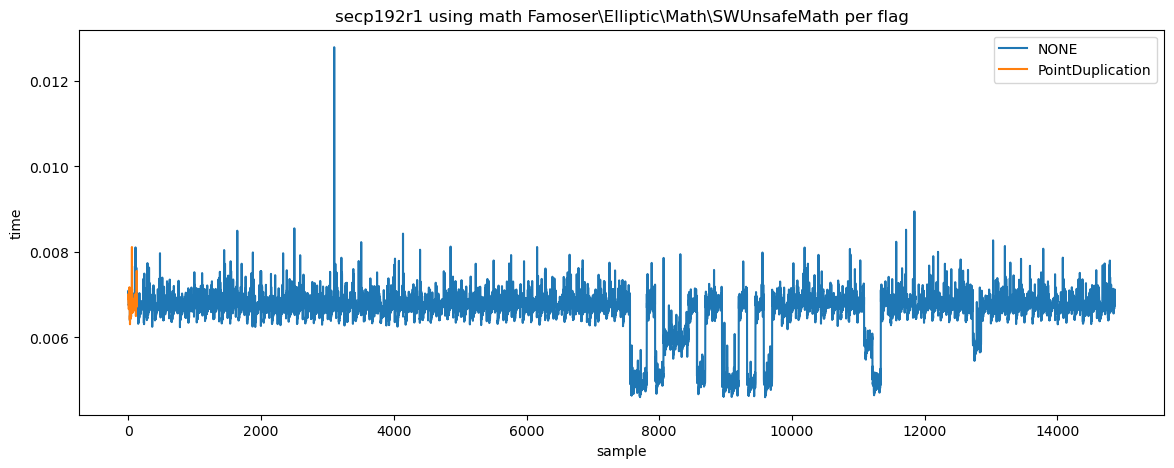

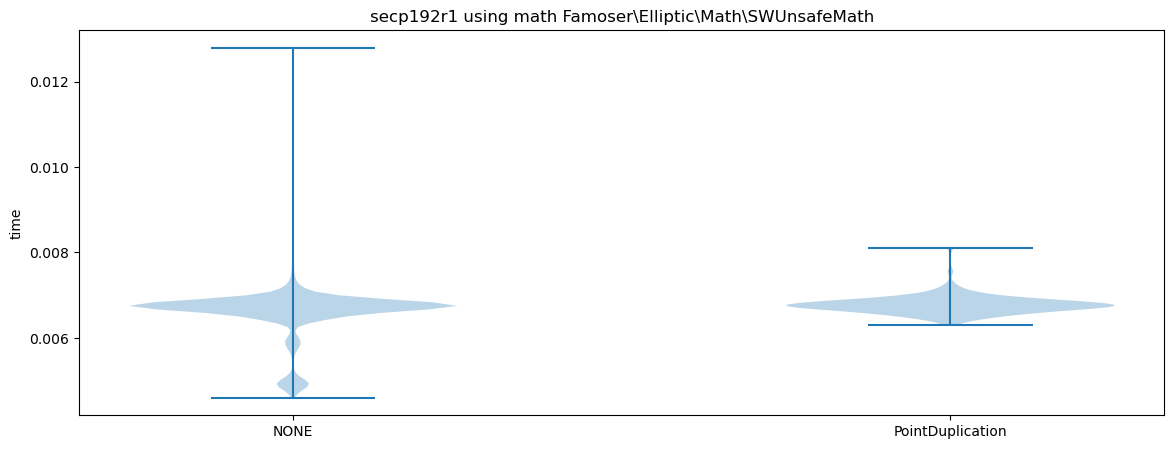

P-value PointDuplication: 2.7094525977331943e-17


In [68]:
measurements_per_flag = get_measurements_per_flag(cleaned_samples)

plt.figure(figsize=(14,5))
for flag in measurements_per_flag:
  plt.plot(measurements_per_flag[flag], label=flag)
plt.title(data['curve'] + ' using math ' + data['math'] + ' per flag')
plt.xlabel('sample')
plt.ylabel('time')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.violinplot(measurements_per_flag.values())
plt.xticks(list(range(1, len(measurements_per_flag.keys()) + 1)), measurements_per_flag.keys())
plt.title(data['curve'] + ' using math ' + data['math'])
plt.ylabel('time')
plt.show()


for flag in measurements_per_flag:
    if flag == 'NONE':
        continue

    # equal_var=False ensures we do not assume equal variance between the two testsets
    result=ss.ttest_ind(measurements_per_flag['NONE'], measurements_per_flag[flag], axis=0, equal_var=False)
    print(f"P-value {flag}: {result.pvalue}")

## 3.2. Measurement per sample

We quantify by testcase.


In [70]:
def get_measurements_per_sample(samples):
    measurements_per_sample = {}
    for sample in samples:
        measurements = []
        for measurement in sample['measurements']:
            measurements.append(measurement['time'])

        measurements_per_sample[sample['id']] = measurements

    return measurements_per_sample

def get_all_measurements(samples):
    measurements = []
    for sample in samples:
        for measurement in sample['measurements']:
            measurements.append(measurement['time'])

    return measurements

baseline = get_all_measurements(cleaned_samples)
measurements_per_sample = get_measurements_per_sample(cleaned_samples)
for sample in measurements_per_sample:
    # equal_var=False ensures we do not assume equal variance between the two testsets
    result=ss.ttest_ind(baseline, measurements_per_sample[sample], axis=0, equal_var=False)
    print(f"P-value {sample}: {result.pvalue}")

KeyError: 'id'